# Лабораторная работа №5

## Начальная обработка данных

Импортируем нужные библиотеки и загружаем X, y. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_diabetes
data = load_diabetes()
X = data.data
y = data.target
N, d = X.shape

Рассчитываем коэффициенты корреляции и строим график. 

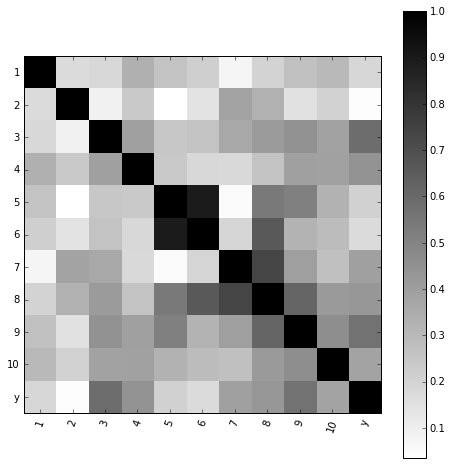

In [2]:
S = np.corrcoef(np.hstack([X, np.reshape(y, (N, 1))]), rowvar = 0)
feature_names = []
for i in range(1, 11):
    feature_names.append(str(i))
feature_names = np.array(feature_names)
    
plt.figure(figsize = (8, 8))
plt.imshow(np.abs(S), interpolation = 'nearest', cmap = 'binary')
plt.colorbar()
plt.xticks(np.arange(d+1), np.append(feature_names,'y'), rotation=70)
plt.yticks(np.arange(d+1), np.append(feature_names,'y'))
pass

Разбиваем данные на тренировочную и тестовую выборки.

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4)
N_train, = y_train.shape
N_test,  = y_test.shape
print (N_train, N_test)

331 111


c:\program files (x86)\python 3.5.2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Создаем модель линейной регрессии.

In [4]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
print(np.mean((y_train_pred - y_train)**2))

y_test_pred = lr_model.predict(X_test)
print(np.mean((y_test_pred - y_test)**2))

2869.757946
2923.90647416


Коэффициенты регресси на обучающей и тестовой выборках.

In [5]:
print(lr_model.score(X_train, y_train))
print(lr_model.score(X_test, y_test))

0.527772418653
0.467076121609


## Отбор и определение значимости признаков.

In [6]:
X /= X.std(axis = 0) # Сделаем стандартизацию!
lr_model.fit(X, y)
lr_model.coef_

array([ -0.47623169, -11.40703082,  24.72625713,  15.42967916,
       -37.68035801,  22.67648701,   4.80620008,   8.422084  ,
        35.73471316,   3.21661161])

Построим самые значимые признаки.

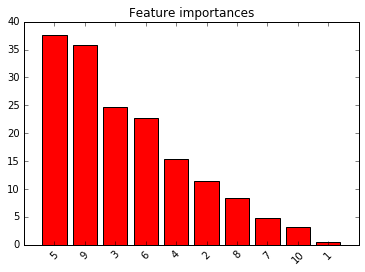

In [7]:
importances = np.abs(lr_model.coef_)
indices = np.argsort(importances)[:-(d + 1):-1]
plt.title("Feature importances")
plt.bar(range(d), importances[indices], align = 'center', color = 'r')
plt.xticks(range(d), feature_names[indices], rotation = 45)
plt.xlim([-1, d])
pass

Отбираем 6 лучших признаков и формируем новые данные X_train_new, X_test_new.

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
kbest_model = SelectKBest(f_regression, k = 6)
kbest_model.fit(X_train, y_train)
X_train_new = kbest_model.transform(X_train)
X_test_new  = kbest_model.transform(X_test)
print (X_train_new.shape, X_test_new.shape)

(331, 6) (111, 6)


Коэффициенты регресси на новых выборках.

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
print(lr_model.score(X_train_new, y_train))
print(lr_model.score(X_test_new, y_test))

0.496230646694
0.472228860278


На тестовой выборке ошибка уменьшилась.

In [10]:
y_train_pred = lr_model.predict(X_train_new)
print(np.mean((y_train_pred - y_train)**2))

y_test_pred = lr_model.predict(X_test_new)
print(np.mean((y_test_pred - y_test)**2))

3061.4393604
2895.6357838


Построим график ошибки при разном количестве признаков.

In [11]:
y_train_mean = np.mean(y_train)
err_train = [np.mean((y_train_mean - y_train)**2)]
err_test  = [np.mean((y_train_mean - y_test)**2)]
for k in range(1, d + 1):
    kbest_model = SelectKBest(f_regression, k = k)
    kbest_model.fit(X_train, y_train)
    X_train_new = kbest_model.transform(X_train)
    X_test_new  = kbest_model.transform(X_test)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train_new, y_train)
    
    y_train_pred = lr_model.predict(X_train_new)
    err_train.append(np.mean((y_train_pred - y_train)**2))
    
    y_test_pred = lr_model.predict(X_test_new)
    err_test.append(np.mean((y_test_pred - y_test)**2))

Наилучшее количество признаков и ошибка в этом случае.

In [12]:
k_opt = np.argmin(err_test)
print (k_opt, err_test[k_opt])

2 2818.95713909


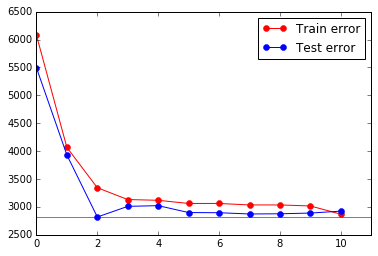

In [13]:
plt.axhline(err_test[k_opt], color = 'gray')
plt.plot(range(d + 1), err_train, 'o-r', label = 'Train error', markeredgecolor = 'r')
plt.plot(range(d + 1), err_test,  'o-b', label = 'Test error',  markeredgecolor = 'b')
plt.legend(loc = 1)
plt.xlim(0, d+1)
pass

Отбор признаков с помощью метода Recursive feature selection.

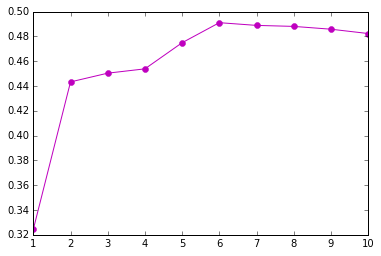

In [14]:
from sklearn.feature_selection import RFECV
lr_model = LinearRegression()
selector = RFECV(lr_model, cv = 5)
selector.fit(X, y)
plt.plot(np.arange(1, d + 1), selector.grid_scores_, 'mo-', markeredgecolor = 'm')
pass

# Вторая часть лабораторной работы
## Остальная часть на листочке (фотографии в приложении)

[[5 1 3]
 [1 3 1]
 [3 1 3]]
[[16]
 [ 2]
 [14]]
[[ 1.]
 [-1.]
 [ 4.]]
[[ 1.5]
 [-0.5]
 [ 2.5]]


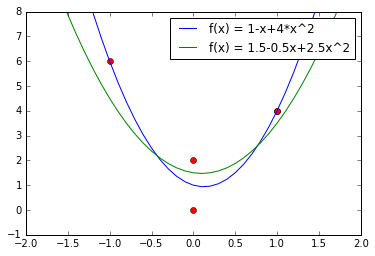

In [15]:
X_ = np.matrix("1 1 1; 1 1 1; 1 0 0; 1 0 0; 1 -1 1")
y_ = np.matrix("4 4 0 2 6")
print(X_.T*X_)
print(X_.T*y_.T)
print(np.linalg.solve(X_.T*X_,X_.T*y_.T))
print(np.linalg.solve(X_.T*X_ + np.identity(3),X_.T*y_.T))
x = np.arange(-2,2,0.1)
y1 = 1-x+4*x*x
y2 = 1.5-0.5*x+2.5*x*x
plt.plot([1,1,0,0,-1],[4,4,0,2,6],'ro')
plt.plot(x,y1,'b',label = 'f(x) = 1-x+4*x^2')
plt.plot(x,y2,'g',label = 'f(x) = 1.5-0.5x+2.5x^2')
plt.legend(loc = 1)
plt.axis([-2, 2, -1, 8]);

# Лабораторная работа №6

## Ridge-регрессия 

$$
\sum_{i=1}^N \left(y^{(i)} - \beta_0 - \sum_{j=1}^d \beta_j x_j^{(i)} \right)^2
+ \alpha \sum_{i=1}^N \beta_j^2
\to \min
$$

In [16]:
from sklearn import linear_model
ridge_model = linear_model.Ridge(alpha = 0.1)
ridge_model.fit(X_train, y_train)
ridge_model.predict(X)
print (ridge_model.score(X_train, y_train))
print (ridge_model.score(X_test, y_test))

0.519317076602
0.467340013565


In [17]:
alphas = np.logspace(0, 7, 200)
coefs = []
for alpha in alphas:
    ridge_model = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    ridge_model.fit(X, y)
    coefs.append(ridge_model.coef_)

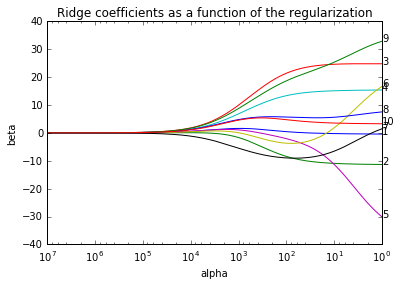

In [18]:
plt.semilogx(alphas, coefs)
plt.xlim(plt.xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Ridge coefficients as a function of the regularization')
for j, feature_name in enumerate(feature_names):
    plt.text(alphas[0], coefs[0][j], feature_name)

In [19]:
err_train = []
err_test = []
alphas = np.logspace(0, 7, 200)
for alpha in alphas:
    ridge_model = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    ridge_model.fit(X_train, y_train)
    
    y_train_pred = ridge_model.predict(X_train)
    err_train.append(np.mean((y_train_pred - y_train)**2))
    
    y_test_pred = ridge_model.predict(X_test)
    err_test.append(np.mean((y_test_pred - y_test)**2))

In [20]:
k_opt = np.argmin(err_test)
print (k_opt, err_test[k_opt])

4 26824.3887416


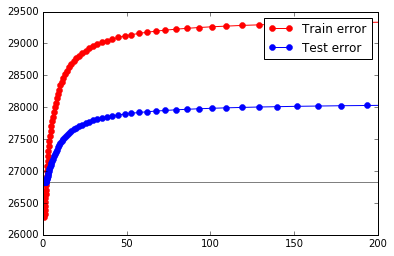

In [21]:
plt.axhline(err_test[k_opt], color = 'gray')
plt.plot(alphas, err_train, 'o-r', label = 'Train error', markeredgecolor = 'r')
plt.plot(alphas, err_test,  'o-b', label = 'Test error',  markeredgecolor = 'b')
plt.legend(loc = 1)
plt.xlim(0, len(alphas))
pass

## LASSO 

LASSO (least absolute shrinkage and selection operator) - 1-регуляризация:

$$
\frac{1}{2N} \sum_{i=1}^N \left(y^{(i)} - \beta_0 - \sum_{j=1}^d \beta_j x_j^{(i)} \right)^2
+ \alpha \sum_{i=1}^N |\beta_j|
\to \min
$$

Если $\alpha$ достаточно велико, то часть найденных коэффициентов $\beta_j$ в точности равны нулю.

In [22]:
lasso_model = linear_model.Lasso(alpha = 0.1)
lasso_model.fit(X_train, y_train)
lasso_model.predict(X)
print (lasso_model.score(X_train, y_train))
print (lasso_model.score(X_test, y_test))

0.51594859046
0.469633647803


[   0.            2.85958204   31.56756058   42.28114854   59.48951185
   68.53177417   73.11077315   91.06683326  100.6353819   104.43208501
  133.29539001  136.17953667  164.57565267]


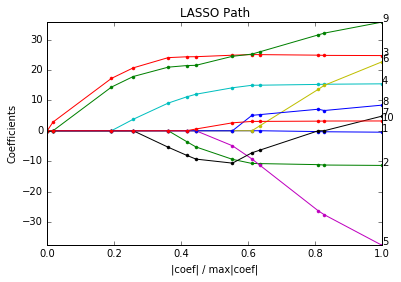

In [23]:
alphas, _, coefs = linear_model.lars_path(X, y, method = 'lasso') # Try method='lar'
xx = np.sum(np.abs(coefs), axis = 0)
print(xx)
xx /= xx[-1]

plt.plot(xx, coefs.T, '.-')
ymin, ymax = plt.ylim()
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')

for j, feature_name in enumerate(feature_names):
    plt.text(1, coefs[j, -1], feature_name)

In [24]:
err_train = []
err_test = []
alphas = np.logspace(0, 7, 100)
for alpha in alphas:
    lasso_model = linear_model.Lasso(alpha = alpha, fit_intercept = False)
    lasso_model.fit(X_train, y_train)
    
    y_train_pred = lasso_model.predict(X_train)
    err_train.append(np.mean((y_train_pred - y_train)**2))
    
    y_test_pred = lasso_model.predict(X_test)
    err_test.append(np.mean((y_test_pred - y_test)**2))

In [25]:
k_opt = np.argmin(err_test)
print (k_opt, err_test[k_opt])

0 26670.1463475


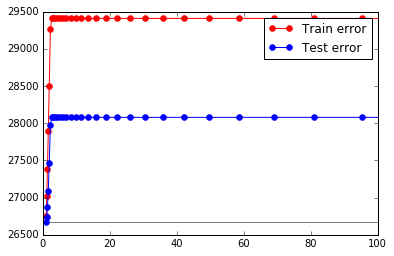

In [26]:
plt.axhline(err_test[k_opt], color = 'gray')
plt.plot(alphas, err_train, 'o-r', label = 'Train error', markeredgecolor = 'r')
plt.plot(alphas, err_test,  'o-b', label = 'Test error',  markeredgecolor = 'b')
plt.legend(loc = 1)
plt.xlim(0, len(alphas))
pass